# Optymalizacja 

## Obwód kwantowy z optymalizacją

- Napisz obwód kwantowy, który zawierać będzie tylko bramkę $R_X$ dla dowolnego parametru $\theta$
- oblicz i uzasadnij, że wartość oczekiwana dla stanu $\ket{\psi} = R_X \, \ket{0}$ 
$$<Z> = cos^2(\theta /2)- sin^2(\theta /2) = cos(\theta)$$


Załóżmy, że nasz problem obliczeniowy sprowadza się do wygenerowania wartości oczekiwanej o wartości 0.5. 

$$
 \textbf{<Z>} = \bra{\psi} \textbf{Z} \ket{\psi} = 0.5
 $$

 

Napisz program znajdujący rozwiązanie - szukający wagę $\theta$ dla naszego obwodu

- Zdefiniuj funkcję kosztu, którą bedziemy minimalizować $(Y - y)^2$
- zainicjuj rozwiązanie $theta=0.01$ i przypisz do tablicy array `np.array(0.01, requires_grad=True)`
- Jako opt wybierz spadek po gradiencie : opt = qml.GradientDescentOptimizer(stepsize=0.1)
- uzyj poniższego kodu do wygenerowania pętli obiczeń 

In [ ]:
# Rozwiązanie 

import pennylane as qml
from pennylane import numpy as np 

dev = qml.device('default.qubit', wires=1)

@qml.qnode(dev)
def par_c(theta):
    qml.RX(theta, wires=0)
    return qml.expval(qml.PauliZ(0))


def cost_fn(theta):
    return (par_c(theta) - 0.5)**2

theta = np.array(0.01, requires_grad=True)

opt = qml.GradientDescentOptimizer(stepsize=0.1)

epochs = 100

for epoch in range(epochs):
    theta = opt.step(cost_fn, theta)

    if epoch % 10 == 0:
        print(f"epoka: {epoch}, theta: {theta}, koszt: {cost_fn(theta)}")

print(f"Optymalizacja zakonczona dla theta={theta}, koszt: {cost_fn(theta)}")

Jeszcze jeden przykład

- Napisz obwód kwantowy, który zawierać będzie bramkę $R_X$ dla parametru $\theta_1$ oraz $R_Y$ dla parametru $\theta_2$
- oblicz i uzasadnij, że wartość oczekiwana dla stanu $\ket{\psi} = R_Y(\theta_2) R_X(\theta_1) \, \ket{0}$ 

$$<Z>  = \cos(\theta_1) \cos(\theta_2)$$

Mozliwe wartości średniej zawierają się w przedziale $-1$, $1$.

Przyjmij załozenie, ze optymalne rozwiązanie realizowane jest dla wartości oczekiwanej = 0.4 

In [ ]:
import pennylane as qml
from pennylane import numpy as np 

dev = qml.device('default.qubit', wires=1)

@qml.qnode(dev)
def par_c(theta):
    qml.RX(theta[0], wires=0)
    qml.RY(theta[1], wires=0)
    return qml.expval(qml.PauliZ(0))


def cost_fn(theta):
    return (par_c(theta) - 0.4)**2

theta = np.array([0.01, 0.02], requires_grad=True)

opt = qml.GradientDescentOptimizer(stepsize=0.1)

epochs = 100

for epoch in range(epochs):
    theta = opt.step(cost_fn, theta)

    if epoch % 10 == 0:
        print(f"epoka: {epoch}, theta: {theta}, koszt: {cost_fn(theta)}")

print(f"Optymalizacja zakonczona dla theta={theta}, koszt: {cost_fn(theta)}")

## VQE 

Celem jest znalezienie najmnieszej wartości własnej dla Hamiltonianu $H = Z_0 Z_1 + Z_0$

Tego typu hamiltoniany opisują układy fizyczne np. systemy spinowe. 

$Z_0 Z_1$ - mozna interpretować jako krawedz miedzy dwoma wierzchołkami. 

$Z_0$ - efekty lokalne wierzchołka 0

In [ ]:
import pennylane as qml
from pennylane import numpy as np 
import random

dev = qml.device("default.qubit", wires=2)

H = qml.PauliZ(0) @ qml.PauliZ(1) + qml.PauliZ(0)

@qml.qnode(dev)
def circuit(params):
    qml.RY(params[0], wires=0)
    qml.RY(params[1], wires=1)
    qml.CNOT(wires=[0,1])
    return qml.expval(H)

def cost_fn(params):
    return circuit(params)

init_param = [random.uniform(0, 2*3.1415) for _ in range(2)]

params = np.array(init_param, requires_grad=True)

opt = qml.GradientDescentOptimizer(stepsize=0.01)

epochs = 500
for epoch in range(epochs):
    params = opt.step(cost_fn, params)

    if epoch % 50 == 0:
        print(f"epoka: {epoch}, theta: {params}, koszt: {cost_fn(params)}")

print(f"Optymalizacja zakonczona dla theta={params}, koszt: {cost_fn(params)}")

# Zadanie

Jesteś firmą organizującą przyjęcia. 

Poproszono Cię o zorganizowanie 5 róznych eventów na Sobotę i Niedzielę. 
Kazde przyjęcie zaplanowane jest na cały dzień -> Jeśli dwa eventy odbywają się w tym samym dniu to jedna osoba nie moze pojawić się na dwóch przyjęciach. 

Posiadamy listę czterech osób i ich preferencje. 

1. E1, E4
2. E2, E3
3. E4, E5
4. E3, E4

Problem ten mozna zareprezentować jako problem typu QUBO (ang. quadratic unconstrained binary optimization)

Zdefiniujmy graf, którego wierzchołki (nodes) to wydarzenia (eventy), natomiast krawędzie (edges) to osoby, które łączą dwa wydazenia jeśli dana osoba jest zainteresowana (dwoma) wydarzeniami. 
Rozwiązanie zadania mozna uzyskać poprzez pokolorowanie grafu na dwa kolory (biały - sobota , czarny - niedziela) - Znalezienie optymalnego podziału kolorów tak aby edge nie łączył tych samych kolorów (nie da się iść na dwa eventy w tym samym czasie).

Rozwiązanie: 

wprowadźmy pięć zmiennych $x_i = x_1, x_2, x_3, x_4, x_5$. 

Wszystkim $x_i$ trzeba przypisać dwie wartości 0 event w sobotę lub 1 event w niedzielę.

Do optymalizacji potrzebujemy funkcję $f(x_1,...,x_5)  = 1 + x_1 + x_4 - 2 x_1 x_4 + ...$

$$f(x_1,...,x_5)  = 1 + x_1 + x_4 - 2 x_1 x_4 + $$
$$ 1 + x_2 + x_3 - 2 x_2 x_3 + $$
$$ 1 + x_4 + x_5 - 2 x_4 x_5 + $$
$$ 1 + x_3 + x_4 - 2 x_3 x_4$$

czynnik 1 dodajemy gdyby ktoś poszedł na event i w sobotę i w niedzielę. 

## QUBO - Quadratic unconstrained binary optimization

[Wiki info](https://en.wikipedia.org/wiki/Quadratic_unconstrained_binary_optimization)

[Artykuł](https://leeds-faculty.colorado.edu/glover/454%20-%20xQx%20survey%20article%20as%20published%202014.pdf)

[Artykuł 2](https://arxiv.org/pdf/1811.11538) - bardzo dobry przykład uzycia

[Lista problemów zdefiniowanych jako problem QUBO](https://blog.xa0.de/post/List-of-QUBO-formulations/)


- logistyka,
- planowanie, 
- optymalizacja portfolio,
- ...

Combinatorial optimization problems are problems involving a large number of yes/no decisions with each set of decisions yielding a corresponding objective function value, like a cost or profit value.

Because of the combinatorial explosion of the solution space with the number of variables, finding good solutions is extremely difficult.

The QUBO model unifies a rich variety of NP-hard combinatorial optimization problems:

- Quadratic Assignment Problems 
- Capital Budgeting Problems
- Task allocation Problems
- Maximum--Cut Problems

QUBO objective function:

$$
F(q) = \sum_a v_a x_a + \sum_{a < b} \omega_{a b} x_a x_b 
$$
gdzie $q_a \in \{0,1\}$, $v_a$ oraz $\omega_a$ to rzeczywiste współczynniki dla liniowej i kwadratowej części.

Rozwiązanie QUBO jest problemem NP-trudnym.

Wprowadźmy zamianę zmiennych: 
$$ 
x_i = 1/2 (1 - z_i)
$$ 
gdzie $z \in {-1,1}$

$$ 
F(z) = \sum_a h_a z_a + \sum_{a < b} J_{a b} z_a z_b 
$$ 


Jak to zagadnienie wrzucić na komputer kwantowy 

Korzystając z zamiany zmiennych 
$$f(z_1,...,z_5)  = 6 - \frac{1}{2} z_1 z_4 - \frac{1}{2} z_2 z_3 - \frac{1}{2} z_4 z_5 - \frac{1}{2} z_3 z_4 $$

Mozemy teraz przygotować "Hamiltonian" dla tej konfiguracji - zamieniamy zmienne $z_i$ na macierze Pauliego $Z_i$

In [ ]:
import pennylane as qml
from pennylane import numpy as np 

# H = 6* qml.Identity(1) - \ 
# 0.5 * qml.PauliZ(1) @ qml.PauliZ(4) - \
# 0.5 * qml.PauliZ(2) @ qml.PauliZ(3) - \
# 0.5 * qml.PauliZ(4) @ qml.PauliZ(5) - \
# 0.5 * qml.PauliZ(3) @ qml.PauliZ(4)

# bo chcemy minimalizować 
H = - 6 * qml.Identity(0) +  \
    0.5 * qml.PauliZ(0) @ qml.PauliZ(3) + \
    0.5 * qml.PauliZ(1) @ qml.PauliZ(2) +  0.5 * qml.PauliZ(3) @ qml.PauliZ(4) +  0.5 * qml.PauliZ(2) @ qml.PauliZ(3)

print(H, H.wires)

dev = qml.device("default.qubit",  H.wires)

@qml.qnode(dev)
def circuit(params):
    for param, wire in zip(params, H.wires):
        qml.RY(param, wires=wire)
    return qml.expval(H)


Załózmy, ze wszystkie osoby poszly w ten sam dzień 

In [ ]:
circuit([0,0,0,0,0])

In [ ]:
params = np.random.rand(len(H.wires))
opt = qml.GradientDescentOptimizer(stepsize=0.5)
epochs = 200

for epoch in range(epochs):
    params = opt.step(circuit, params)

    if epoch % 50 == 0:
        print(f"epoka: {epoch}, theta: {params}, koszt: {circuit(params)}")

print(f"Optymalizacja zakonczona dla theta={params}, koszt: {circuit(params)}")

In [ ]:
dev = qml.device("default.qubit",  H.wires, shots=1)

@qml.qnode(dev)
def results(params):
    for param, wire in zip(params, H.wires):
        qml.RY(param, wires=wire)
    return qml.sample()

In [ ]:
results(params)

Bramki kwantowe realizowane są w modelu bramkowym przez `operatory unitarne` reprezentowane przez macierze.

$$
U U^{\dagger} = U^{\dagger} U = I 
$$

Kazda macierz unitarna moze być przedstawiona jako: 

$$ 
U(H,t) = e^{-i H t}
$$
gdzie $H$ to macierz Hermitowska ($H=H^{\dagger}$)

W ogólności, implementacja obwodu kwantowego, który dokładnie realizuje macierz unitarną dla zadanego 
Hamiltonianiu jest bardzo trudnym zadaniem. Hamiltonian taki zazwyczaj składa się z sumy wielu niekomutujących części.  

$$ 
H = H_1 + H_2 + \dots + H_n
$$ 


Rozwazmy pierwszy prosty przypadek gdzie nasza macierz $H$ realizowana jest przez operator Pauliego $Z$.

Chcielibyśmy znaleźć tzn poziom podstawowy operatora $H$, czyli jego wektor własny dla którego ma on najmniejszą wartość własną. 
Takie podejście powinno kojarzyć się nam z wymogiem minimalizacji funkcji straty. 
$$ H\ket{E_0} = E_0\ket{E_0} $$

W przypadku gdy $H = Z$ mamy dwa stany $\ket{0}$ i $\ket{1}$ 

$$ Z\ket{0} = 1 \ket{0} $$

$$ Z\ket{1} = -1 \ket{1} $$

Czyli stanem o najmniejszej wartości własnej jest stan $\ket{1}$.

Załózmy, ze nie znamy tej informacji!!! 

Algorytm QAOA 

1. Przygotuj obwód i zastosuj bramkę Hadamarda - stan superpozycji ($\ket{+} = H\ket{0}$)
2. Dokonujemy ewolucji czasowej naszego operatora $Z$ 
$$ e^{-itZ}\ket{+}  = \frac{1}{\sqrt{2}}(e^{-it}\ket{0} + e^{it}\ket{1})$$
3. Zastosujmy dodatkowo bramkę $R_X(-\theta)$ 
$$  R_x(- \theta) \frac{1}{\sqrt{2}}(e^{-it}\ket{0} + e^{it}\ket{1})$$
$$  \frac{1}{\sqrt{2}}\left( (e^{-it} cos(\theta /2 + i e^{it}sin(\theta /2)) \ket{0} + (ie^{-it} sin(\theta /2 + e^{it} cos(\theta /2))\ket{1}) \right)$$

Dla $t = \pi/4 $ oraz $\theta = \pi /2$ otrzymujemy stan $\ket{1}$

Nazewnictwo: 

1. Cost Hamiltonian:  $H_{cost} = Z$  
2. Mixer Hamiltonian:  $H_{mixer} = X$  bo $R_x(t) = e^{-itX}$

Mozemy wykorzystać wzór  `Trotter'a-Suzuki` który przybliza dowolną sumę macierzy 
$$ 
e^{A + B} \approx \left( e^{A/n} e^{B/n} \right)^n
$$ 
 
dlatego dla  $H=\sum_k H_k$ otrzymujemy
$$ U(H,t,n) = \prod_{j=1}^n \prod_k e^{-i H_k t/n} $$

## Quantum Approximate Optimization Algorithm 

QAOA mozna zastosować do nietrywialnych problemów kombinatorycznych (optymalizacyjnych). 

Jest on przykładem realizacji `VQA` czyli `wariacyjnych algorytmów kwantowych` opartych na (`PQC`) `parametryzowanych obwodów kwantowych`.

Mozna uruchomić go na współcześnie dostępnych komputerach kwantowych. Nie wymaga skomplikowanych bramek. 



In [1]:
import pennylane as qml
from pennylane import numpy as np 

from pennylane import qaoa

import matplotlib.pyplot as plt 
import cmath

In [2]:
cost_H = qml.Hamiltonian(
    [1,1,1],
    [qml.PauliZ(0), qml.PauliZ(1), qml.PauliZ(2)]
    ) # minimum dla |111> 
mixer_H  = qml.Hamiltonian(
    [1,1,1],
    [qml.PauliX(0), qml.PauliX(1), qml.PauliX(2)]
    ) 

wires = cost_H.wires
print(wires)

# circuit - one layer = H_cos + H mix

num_layers = 5 

def qoao_layer(gamma, alpha):
    qaoa.cost_layer(gamma, cost_H)
    qaoa.mixer_layer(alpha, mixer_H)

def circuit(params):
    for w in wires:
        qml.Hadamard(w)
    qml.layer(qoao_layer, num_layers, params[0], params[1]) # potwarza layer n razy

dev = qml.device('default.qubit', wires=wires)

@qml.qnode(dev)
def cost_function(params):
    circuit(params)
    return qml.expval(cost_H)


<Wires = [0, 1, 2]>


In [3]:
params = np.array([[0.5]*num_layers, [0.5]*num_layers], requires_grad=True)


opt = qml.GradientDescentOptimizer()
epochs = 100

for epoch in range(epochs):
    params = opt.step(cost_function, params)


print(f"Optymalizacja zakonczona dla theta={params}, koszt: {cost_function(params)}")

Optymalizacja zakonczona dla theta=[[0.44741266 0.59627289 0.48116583 0.23007397 0.25139093]
 [0.25139093 0.23007397 0.48116583 0.59627289 0.44741266]], koszt: -2.9999999999999827


In [4]:
@qml.qnode(dev)
def circuit_state(params):
    circuit(params)
    return qml.state()


np.round_(circuit_state(params),  decimals=5)

tensor([ 0.-0.j,  0.-0.j,  0.-0.j, -0.-0.j,  0.-0.j, -0.-0.j, -0.-0.j,
        -1.+0.j], requires_grad=True)

In [5]:
@qml.qnode(dev)
def probability_circuit(gamma, alpha):
    circuit([gamma, alpha])
    return qml.probs(wires=wires)


probs = probability_circuit(params[0], params[1])

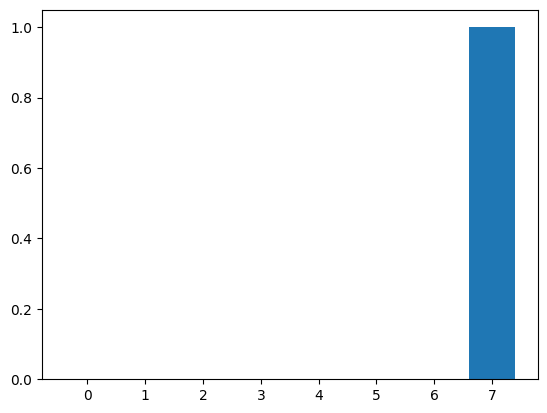

In [7]:

plt.bar(range(2 ** len(wires)), probs)
plt.show()

### Max-cut 



In [8]:
from pennylane import qaoa
from pennylane import numpy as np
from matplotlib import pyplot as plt
import networkx as nx

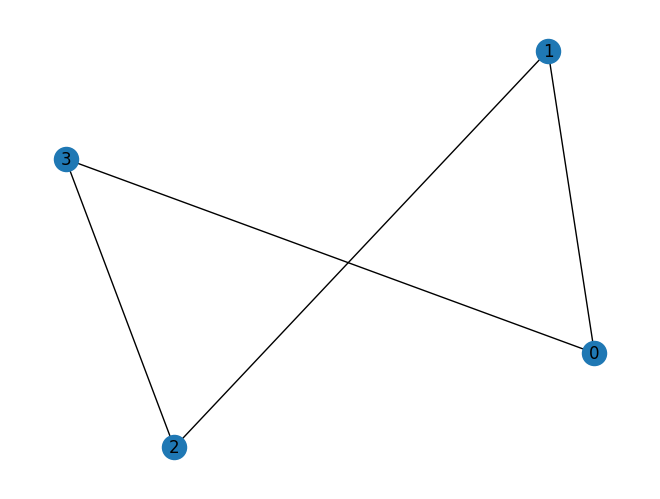

In [9]:
edges = [(0, 1), (1, 2),(2,3),(3,0)]
graph = nx.Graph(edges)
nx.draw(graph, with_labels=True)
plt.show()

In [10]:
cost_h, mixer_h = qaoa.min_vertex_cover(graph, constrained=False)

print("Cost Hamiltonian", cost_h)
print("Mixer Hamiltonian", mixer_h)

Cost Hamiltonian 0.75 * (Z(0) @ Z(1)) + 0.75 * Z(0) + 0.75 * Z(1) + 0.75 * (Z(0) @ Z(3)) + 0.75 * Z(0) + 0.75 * Z(3) + 0.75 * (Z(1) @ Z(2)) + 0.75 * Z(1) + 0.75 * Z(2) + 0.75 * (Z(2) @ Z(3)) + 0.75 * Z(2) + 0.75 * Z(3) + -1.0 * Z(0) + -1.0 * Z(1) + -1.0 * Z(2) + -1.0 * Z(3)
Mixer Hamiltonian 1 * X(0) + 1 * X(1) + 1 * X(2) + 1 * X(3)


In [11]:
def qaoa_layer(gamma, alpha):
    qaoa.cost_layer(gamma, cost_h)
    qaoa.mixer_layer(alpha, mixer_h)


In [12]:
wires = cost_h.wires
depth = 2


def circuit(params, **kwargs):
    for w in wires:
        qml.Hadamard(wires=w)
    qml.layer(qaoa_layer, depth, params[0], params[1])

In [14]:
dev = qml.device("default.qubit", wires=wires)


@qml.qnode(dev)
def cost_function(params):
    circuit(params)
    return qml.expval(cost_h)

In [15]:
optimizer = qml.GradientDescentOptimizer()
steps = 70
params = np.array([[0.5, 0.5], [0.5, 0.5]], requires_grad=True)

In [16]:
for i in range(steps):
    params = optimizer.step(cost_function, params)

print("Optimal Parameters")
print(params)

Optimal Parameters
[[0.63141524 1.02160759]
 [0.51521978 0.86666078]]


In [17]:
@qml.qnode(dev)
def probability_circuit(gamma, alpha):
    circuit([gamma, alpha])
    return qml.probs(wires=wires)


probs = probability_circuit(params[0], params[1])

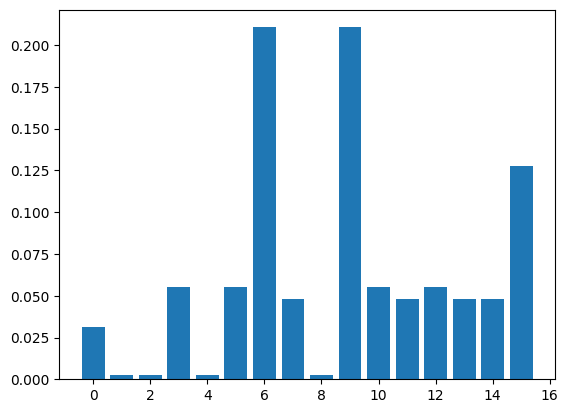

In [18]:
plt.bar(range(2 ** len(wires)), probs)
plt.show()

In [20]:
('{0:04b}'.format(6), '{0:04b}'.format(9))

('0110', '1001')